In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

import statsmodels.api as sm

# Число визитов к доктору

Изучается функционирование системы здравоохранения Австралии. Для 1500 одиноких совершеннолетних граждан известны значения следующих показателей:

* социоэкономические:
    * пол
    * возраст, лет;
    * годовой доход, 10 тыс. долл.;
* индикаторы наличия страховки различных типов: 
    * частной, государственной для малоимущих, государственной для пожилых, инвалидов и ветеранов;
* краткосрочные характеристики здоровья:
    * число визитов к доктору за последние две недели;
    * число заболеваний за последние две недели;
    * число дней сниженной активности в связи с заболеванием или травмой за последние две недели;
* долгосрочные характеристики здоровья:
    * оценка состояния здоровья по опроснику Голдберга;
    * индикаторы наличия хронических заболеваний, ограничивающих и не ограничивающих активность.

Требуется построить модель числа визитов к доктору в зависимости от остальных признаков.

**Cameron C. A., Trivedi P. K. Regression Analysis of Count Data. Cambridge University Press, 2013.**

In [2]:
data = pd.read_csv('dvi.txt', delimiter=' ')
data.sample(5)

,SEX,AGE,INCOME,LEVYPLUS,FREEPOOR,FREEREPA,ILLNESS,ACTDAYS,HSCORE,CHCOND1,CHCOND2,DVISITS
1443,m,37.000000,1.50,1,0,0,1,0,0,0,0,0
1487,m,19.000000,0.15,0,0,0,4,0,4,0,1,0
1024,m,31.999999,0.15,0,1,0,2,5,3,0,0,0
851,m,27.000001,0.75,0,0,0,3,0,5,0,0,0
1094,m,22.000000,0.25,1,0,0,3,0,2,0,0,0


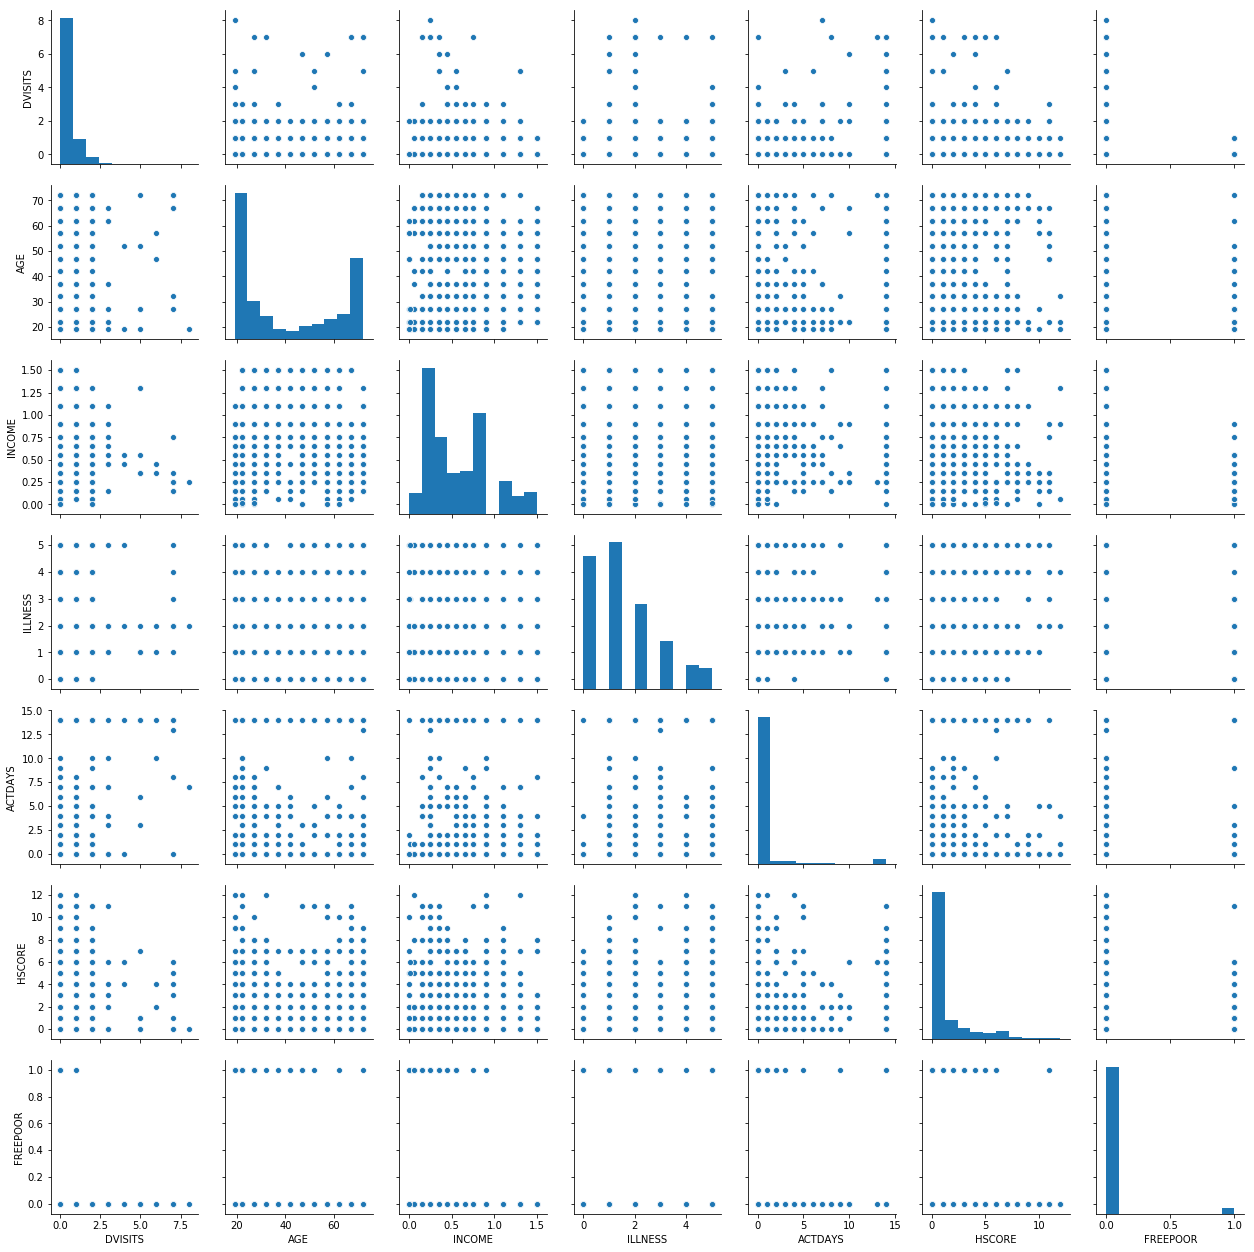

In [3]:
_ = sns.pairplot(data[['DVISITS', 'AGE', 'INCOME', 'ILLNESS', 'ACTDAYS', 'HSCORE', 'FREEPOOR']])

In [4]:
data['FREEPOOR'].sum()

59

Видим, что в выборке только 59 обладателей государственной страховки для малоимущих, причём только 2 из них когда-либо ходили к врачу. Коэффициент при таком признаке будет определяться неустойчиво. Исключим эти 59 наблюдений и признак.

In [5]:
data2 = data[data['FREEPOOR']==0]
data2.shape

(1441, 12)

Стандартная пуассоновская модель:

In [6]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS', 
                             data=data2).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            3190.1662 
Link Function:      identity         BIC:            -9665.0125
Dependent Variable: DVISITS          Log-Likelihood: -1588.1   
Date:               2020-04-14 17:48 LL-Null:        -1821.5   
No. Observations:   1441             Deviance:       764.60    
Df Model:           6                Pearson chi2:   765.      
Df Residuals:       1434             Scale:          0.53320   
Method:             IRLS                                       
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------
Intercept         0.1939   0.0499  3.8845 0.0001  0.0961 0.2918
SEX[T.m]         -0.0999   0.0573 -1.7422 0.0815 -0.2122 0.0125
ILLNESS           0.0835   0.0192  4.3541 0.0000  0.0459 0.1211
SEX[T.m]:ILLNESS  0.0047   0.0285  0.1645 0.8694 -0.0511 0.0605
ACTDAYS           0.1376   0.0137 10.0479 0.0000  0.1108 0.1645
INCOME           -0.1015   0.0534 -1.9007 0.0573 -0.2062 0.0032
ILLNESS:ACTDAYS  -0.0002   0.0055 -0.0351 0.9720 -0.0110 0.0106
===============================================================

"""

Показатель overdispersion/underdispersion:  ```chi2 / Df Residuals```

Отрицательная биномиальная модель:

In [7]:
model = sm.GLM.from_formula('DVISITS~SEX+AGE+INCOME+LEVYPLUS+FREEREPA+ILLNESS+ACTDAYS+HSCORE+CHCOND1+CHCOND2',
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            1785.5341 
Link Function:      log              BIC:            -9564.3663
Dependent Variable: DVISITS          Log-Likelihood: -881.77   
Date:               2020-04-14 17:48 LL-Null:        -1037.6   
No. Observations:   1441             Deviance:       836.16    
Df Model:           10               Pearson chi2:   1.40e+03  
Df Residuals:       1430             Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept   -1.9233    0.2244  -8.5722  0.0000  -2.3630  -1.4835
SEX[T.m]    -0.3677    0.1297  -2.8362  0.0046  -0.6218  -0.1136
AGE          0.0043    0.0039   1.0880  0.2766  -0.0034   0.0120
INCOME      -0.3401    0.1917  -1.7745  0.0760  -0.7158   0.0356
LEVYPLUS    -0.0109    0.1595  -0.0682  0.9456  -0.3236   0.3018
FREEREPA    -0.1976    0.2220  -0.8901  0.3734  -0.6327   0.2375
ILLNESS      0.2903    0.0449   6.4710  0.0000   0.2024   0.3782
ACTDAYS      0.1709    0.0135  12.6914  0.0000   0.1445   0.1972
HSCORE       0.0354    0.0258   1.3715  0.1702  -0.0152   0.0861
CHCOND1      0.0333    0.1473   0.2261  0.8211  -0.2554   0.3220
CHCOND2      0.1296    0.1961   0.6609  0.5087  -0.2547   0.5139
===============================================================

"""

Удалим незначимые признаки:

In [8]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS',
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            1779.3163 
Link Function:      log              BIC:            -9607.4957
Dependent Variable: DVISITS          Log-Likelihood: -885.66   
Date:               2020-04-14 17:48 LL-Null:        -1037.6   
No. Observations:   1441             Deviance:       843.94    
Df Model:           3                Pearson chi2:   1.44e+03  
Df Residuals:       1437             Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
            Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept  -1.9482    0.1158  -16.8217  0.0000  -2.1752  -1.7212
SEX[T.m]   -0.4275    0.1231   -3.4734  0.0005  -0.6688  -0.1863
ILLNESS     0.3293    0.0389    8.4599  0.0000   0.2530   0.4056
ACTDAYS     0.1770    0.0128   13.8316  0.0000   0.1519   0.2020
===============================================================

"""

Попробуем возвращать по одному удалённые признаки:

In [9]:
formula = 'DVISITS~SEX+ILLNESS+ACTDAYS+'
for p in ['AGE','INCOME','LEVYPLUS','FREEREPA','HSCORE','CHCOND1','CHCOND2']:
    model = sm.GLM.from_formula(formula+p, data=data2, family=sm.families.NegativeBinomial()).fit()
    print (p, model.bic)

AGE -9601.95798792102
INCOME -9604.156703389735
LEVYPLUS -9600.22267074508
FREEREPA -9600.38972029986
HSCORE -9602.253492466225
CHCOND1 -9600.22262182329
CHCOND2 -9600.881835865213


Лучше всего модель, в которую возвращён доход:

In [10]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME',
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            1777.3822 
Link Function:      log              BIC:            -9604.1567
Dependent Variable: DVISITS          Log-Likelihood: -883.69   
Date:               2020-04-14 17:48 LL-Null:        -1037.6   
No. Observations:   1441             Deviance:       840.00    
Df Model:           4                Pearson chi2:   1.41e+03  
Df Residuals:       1436             Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
            Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept  -1.7671    0.1475  -11.9769  0.0000  -2.0563  -1.4779
SEX[T.m]   -0.3679    0.1264   -2.9115  0.0036  -0.6156  -0.1203
ILLNESS     0.3206    0.0393    8.1640  0.0000   0.2436   0.3976
ACTDAYS     0.1770    0.0128   13.8441  0.0000   0.1520   0.2021
INCOME     -0.3426    0.1745   -1.9637  0.0496  -0.6846  -0.0006
===============================================================

"""

Ещё раз попробуем возвращать по одному удалённые признаки:

In [11]:
formula = 'DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+'
for p in ['AGE','LEVYPLUS','FREEREPA','HSCORE','CHCOND1','CHCOND2']:
    model = sm.GLM.from_formula(formula+p, data=data2, family=sm.families.NegativeBinomial()).fit()
    print (p, model.bic)

AGE -9597.428967802289
LEVYPLUS -9597.239497446899
FREEREPA -9597.069535608369
HSCORE -9598.710746537601
CHCOND1 -9596.885074625992
CHCOND2 -9597.261132485633


Попробуем добавлять значимые межфакторные взаимодействия:

In [12]:
formula = 'DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+'
features = ['SEX', 'ILLNESS', 'ACTDAYS', 'INCOME']
for f1 in range(len(features)):
    for f2 in range(f1+1, len(features)): 
        f1_ = features[f1]
        f2_ = features[f2]
        model = sm.GLM.from_formula(formula+str(f1_)+':'+str(f2_),
                                    data=data2, family=sm.families.NegativeBinomial()).fit()               
        for name, p in model.pvalues.items():
            if p<0.05 and ':' in name:
                print (f1_, f2_, model.bic)
                


SEX ILLNESS -9602.825793657119
ILLNESS ACTDAYS -9606.313252511018
ILLNESS INCOME -9601.963100280722


In [13]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS', data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
================================================================
Model:               GLM              AIC:            1769.9526 
Link Function:       log              BIC:            -9606.3133
Dependent Variable:  DVISITS          Log-Likelihood: -878.98   
Date:                2020-04-14 17:48 LL-Null:        -1037.6   
No. Observations:    1441             Deviance:       830.57    
Df Model:            5                Pearson chi2:   1.40e+03  
Df Residuals:        1435             Scale:          1.0000    
Method:              IRLS                                       
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept       -1.8599   0.1533 -12.1294 0.0000 -2.1605 -1.5594
SEX[T.m]        -0.3420   0.1268  -2.6973 0.0070 -0.5905 -0.0935
ILLNESS          0.3691   0.0425   8.6815 0.0000  0.2858  0.4525
ACTDAYS          0.2449   0.0239  10.2350 0.0000  0.1980  0.2918
INCOME          -0.3677   0.1753  -2.0975 0.0359 -0.7113 -0.0241
ILLNESS:ACTDAYS -0.0323   0.0096  -3.3620 0.0008 -0.0511 -0.0134
================================================================

"""

In [14]:
model.wald_test('ILLNESS:ACTDAYS=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[11.30312164]], p-value=0.0007737688810789982, df_denom=1>

In [15]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS', 
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:                GLM              AIC:            1765.9476 
Link Function:        log              BIC:            -9605.0451
Dependent Variable:   DVISITS          Log-Likelihood: -875.97   
Date:                 2020-04-14 17:48 LL-Null:        -1037.6   
No. Observations:     1441             Deviance:       824.57    
Df Model:             6                Pearson chi2:   1.42e+03  
Df Residuals:         1434             Scale:          1.0000    
Method:               IRLS                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept        -1.6985   0.1619 -10.4909 0.0000 -2.0158 -1.3812
SEX[T.m]         -0.7610   0.2148  -3.5431 0.0004 -1.1820 -0.3400
ILLNESS           0.2923   0.0514   5.6906 0.0000  0.1917  0.3930
SEX[T.m]:ILLNESS  0.2017   0.0820   2.4614 0.0138  0.0411  0.3624
ACTDAYS           0.2435   0.0240  10.1627 0.0000  0.1966  0.2905
INCOME           -0.3608   0.1754  -2.0571 0.0397 -0.7046 -0.0170
ILLNESS:ACTDAYS  -0.0321   0.0096  -3.3376 0.0008 -0.0509 -0.0132
=================================================================

"""

Итоговая модель

KendalltauResult(correlation=0.30733279863104856, pvalue=9.199047228135223e-48)

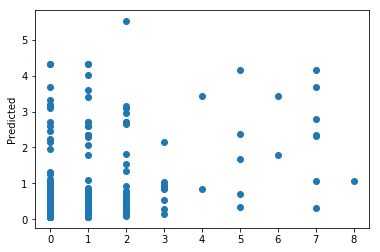

In [16]:
plt.scatter(data2['DVISITS'], model.predict(data2))
plt.ylabel('Predicted')
st.kendalltau(data2['DVISITS'], model.predict(data2))

Для сравнения — обычная линейная модель, не учитывающая счётную природу отклика:

In [17]:
model2 = sm.OLS.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS', 
                             data=data2).fit()
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.242    
Dependent Variable: DVISITS          AIC:                3190.1662
Date:               2020-04-14 17:48 BIC:                3227.0779
No. Observations:   1441             Log-Likelihood:     -1588.1  
Df Model:           6                F-statistic:        77.79    
Df Residuals:       1434             Prob (F-statistic): 2.83e-84 
R-squared:          0.246            Scale:              0.53320  
------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
Intercept            0.1939   0.0499  3.8845 0.0001  0.0960 0.2919
SEX[T.m]            -0.0999   0.0573 -1.7422 0.0817 -0.2123 0.0126
ILLNESS              0.0835   0.0192  4.3541 0.0000  0.0459 0.1211
SEX[T.m]:ILLNESS     0.0047   0.0285  0.1645 0.8694 -0.0512 0.0605
ACTDAYS              0.1376   0.0137 10.0479 0.0000  0.1108 0.1645
INCOME              -0.1015   0.0534 -1.9007 0.0575 -0.2063 0.0033
ILLNESS:ACTDAYS     -0.0002   0.0055 -0.0351 0.9720 -0.0110 0.0107
------------------------------------------------------------------
Omnibus:            1102.829      Durbin-Watson:         2.009    
Prob(Omnibus):      0.000         Jarque-Bera (JB):      30709.545
Skew:               3.303         Prob(JB):              0.000    
Kurtosis:           24.630        Condition No.:         27       
==================================================================

"""

KendalltauResult(correlation=0.30733279863104856, pvalue=9.199047228135223e-48)

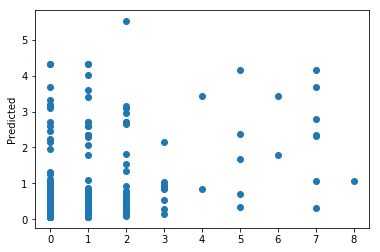

In [18]:
plt.scatter(data2['DVISITS'], model.predict(data2))
plt.ylabel('Predicted')
st.kendalltau(data2['DVISITS'], model.predict(data2))

# Финальная модель

In [19]:
model.params

Intercept          -1.698512
SEX[T.m]           -0.760993
ILLNESS             0.292345
SEX[T.m]:ILLNESS    0.201722
ACTDAYS             0.243537
INCOME             -0.360819
ILLNESS:ACTDAYS    -0.032053
dtype: float64

# Выводы

Модель позволяет сделать следующие выводы:

* При прочих равных женщины обращаются к врачу в 2 раза чаще.
* Каждый день сниженной активности без болезни увеличивает число посещений врача в 1.2 раза.
* Каждая болезнь без снижения активности увеличивает число посещений врача в 1.3 раза у женщин и 1.6 у мужчин.
* При росте на единицу одновременно числа дней сниженной активности и числа заболеваний число визитов к доктору растёт в 1.03 медленнее, чем если бы эти признаки действовали независимо.
* Увеличение годового дохода на 10 тыс. долл. снижает среднее число визитов к врачу в 1.4 раза.

